# Creating Model

In this note book we will be creating the model for prediction.  

When creating the model, we use a basic structure (image branch, text branch, merging the branches, and FC layer(s), and a multi class evaluation output layer). 

The parameter that we can play with out of the box are:  
1. **loss_function**
2. **output_activation_function**
3. **lstm_units** (will use 'Flatten' instead for 0)
4. **post_concat_dense_units** (could be a list to specify multiple layers)
5. **optimizer**
6. **prediction_vector_name** ('answers' / 'words')
7. **question_category** (for limiting the model to Abnormality / Plane / Organ system / Modality / Abnormality_yes_no. The default is one model for all).
8. **use_text_inputs_attention** (Specifies if attention should be applied for the input of the text branch)



### Some main functions we used:

In [1]:
import IPython
from IPython.display import Image, display
from common.functions import get_highlighted_function_code

##### word_2_vec_model
Define how to build the word-to vector branch

In [2]:
from classes.vqa_model_builder import VqaModelBuilder
code = get_highlighted_function_code(VqaModelBuilder.word_2_vec_model,remove_comments=True)
IPython.display.display(code)  

Using TensorFlow backend.


##### get_image_model:
In the same manner, defines how to build the image representation branch:

In [3]:
code = get_highlighted_function_code(VqaModelBuilder.get_image_model,remove_comments=False)
IPython.display.display(code)  

##### And the actual function for getting the model:

In [4]:
code = get_highlighted_function_code(VqaModelBuilder.get_vqa_model,remove_comments=True)
IPython.display.display(code)  

---
## The code:

In [5]:
from classes.vqa_model_builder import VqaModelBuilder
from common.utils import VerboseTimer
import vqa_logger 

In [6]:
prediction_vector_name = 'answers'
question_category = 'Modality'
kw_args = {
'loss_function': 'categorical_crossentropy', 
'output_activation_function': 'softmax',
'lstm_units': 0,
'post_concat_dense_units':(8,6),
'optimizer': 'RMSprop',
'prediction_vector_name': prediction_vector_name,
'question_category': question_category,
'use_text_inputs_attention':False    
}

with VerboseTimer("Instantiating VqaModelBuilder"):
    mb = VqaModelBuilder(**kw_args)

[2021-09-20 11:19:05][common.utils][DEBUG] Starting 'Instantiating VqaModelBuilder'
[2021-09-20 11:19:05][common.utils][DEBUG] Instantiating VqaModelBuilder: 0:00:00.210407


### Creating the model

In [7]:
with VerboseTimer("Gettingt the model"):
    model = mb.get_vqa_model()

[2021-09-20 11:19:05][common.utils][DEBUG] Starting 'Gettingt the model'
[2021-09-20 11:19:05][classes.vqa_model_builder][DEBUG] Getting embedding (lstm model)
[2021-09-20 11:19:05][classes.vqa_model_builder][DEBUG] Creating Embedding model
[2021-09-20 11:19:05][classes.vqa_model_builder][DEBUG] Done Creating Embedding model
[2021-09-20 11:19:05][classes.vqa_model_builder][DEBUG] Getting image model
[2021-09-20 11:25:10][classes.vqa_model_builder][DEBUG] merging final model


C:\Users\avitu\Documents\GitHub\VQA-MED\VQA-MED\VQA.Python\classes\vqa_model_builder.py:171: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("mo...)`
  fc_model = Model(inputs=[lstm_input_tensor, image_input_tensor], output=fc_tensors)


[2021-09-20 11:25:10][common.utils][DEBUG] Gettingt the model: 0:06:05.190695


#### Saving the model:

##### The saving function:

In [8]:
model_folder = VqaModelBuilder.save_model(model, prediction_vector_name, question_category, folder_suffix='')
model_folder

[2021-09-20 11:25:11][data_access.model_folder][DEBUG] model saved
[2021-09-20 11:25:11][data_access.model_folder][DEBUG] saving prediction vector
[2021-09-20 11:25:11][data_access.model_folder][DEBUG] saved prediction vector
[2021-09-20 11:25:11][data_access.model_folder][DEBUG] Writing Summary
[2021-09-20 11:25:11][data_access.model_folder][DEBUG] Done Writing Summary
[2021-09-20 11:25:11][data_access.model_folder][DEBUG] Saving image
[2021-09-20 11:25:12][data_access.model_folder][DEBUG] Image saved ('C:\Users\Public\Documents\Data\2019\models\20210920_1125_10\model.png')
[2021-09-20 11:25:12][classes.vqa_model_builder][INFO] Summary: C:\Users\Public\Documents\Data\2019\models\20210920_1125_10\model_summary.txt
Image: C:\Users\Public\Documents\Data\2019\models\20210920_1125_10\model.png

[2021-09-20 11:25:12][classes.vqa_model_builder][INFO] model_location = 'C:\Users\Public\Documents\Data\2019\models\20210920_1125_10\vqa_model.h5'


ModelFolder(folder="C:\\Users\\Public\\Documents\\Data\\2019\\models\\20210920_1125_10")

### Display a plot + summary:

#### Where are the trainable parameters?

In [9]:
top = VqaModelBuilder.get_trainable_params_distribution(model)

Got a total of 50,565 trainable parameters


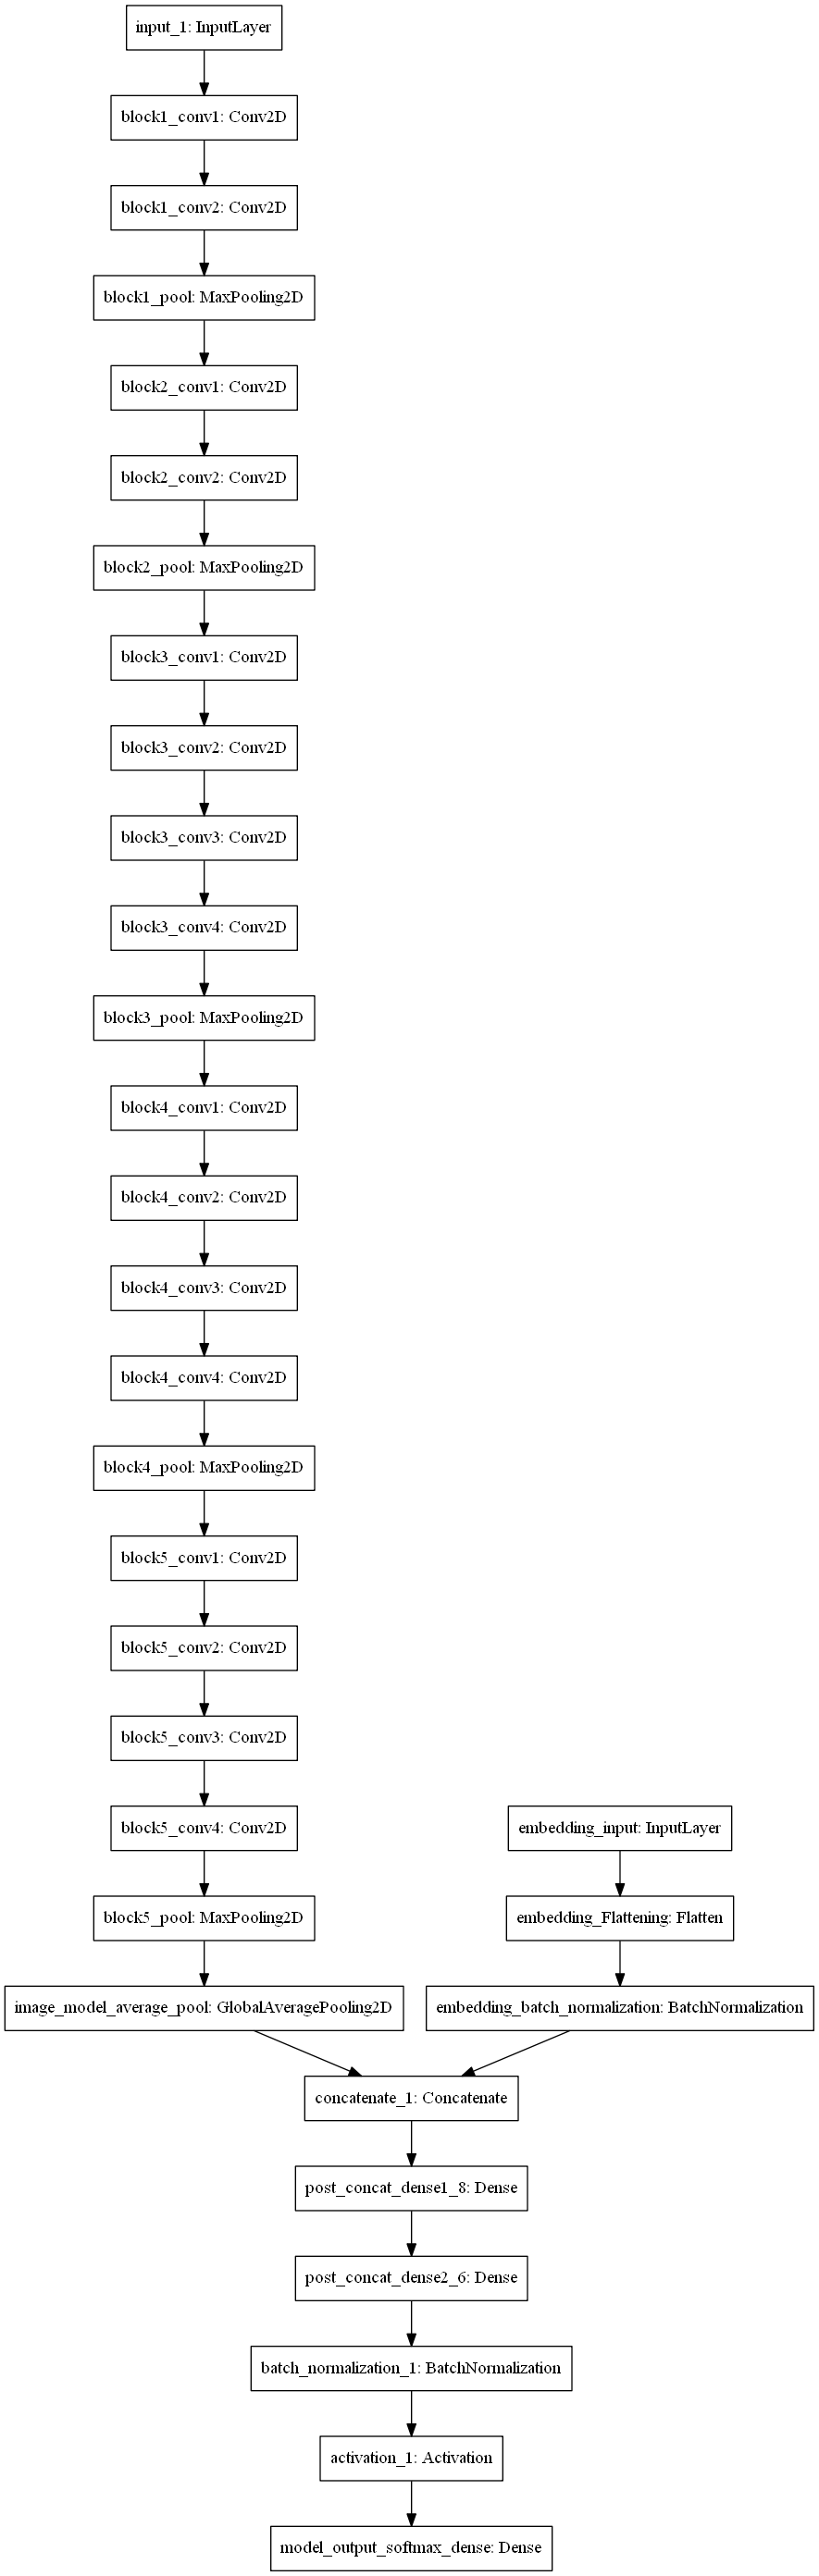

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, None, None, 6 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [10]:
display(Image(filename=str(model_folder.image_file_path)))
model.summary()

Copy these items to the next notebook of training the model

In [11]:
msg = f"Summary: {str(model_folder.summary_path)}\n"
msg += f"Image: {model_folder.image_file_path}\n"
location_message = f"model_location = '{model_folder.model_path}'"


print(msg)
print(location_message.replace('\\', '\\\\'))

Summary: C:\Users\Public\Documents\Data\2019\models\20210920_1125_10\model_summary.txt
Image: C:\Users\Public\Documents\Data\2019\models\20210920_1125_10\model.png

model_location = 'C:\\Users\\Public\\Documents\\Data\\2019\\models\\20210920_1125_10\\vqa_model.h5'
